In [8]:
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import shrimpy
import psycopg2

In [3]:
class DatabaseClient:
    """
    Functionality for inserting and reading from the database
    """

    def __init__(self):
        # Connect to db
        self.con = psycopg2.connect(
            host='localhost',
            database='postgres',
            user='postgres',
            password='postgres'
        )
        self.article_table = pd.DataFrame()

    def read_db(self):
        cur = self.con.cursor()

        cur.execute("SELECT timestamp, comp_sentiment, sma, ema FROM sent_values WHERE timestamp > '2021-01-26 15:00:00'::timestamp;")

        rows = cur.fetchall()

        self.article_table = pd.DataFrame(data=rows, columns=['timestamp','compound','sma','ema'])


        return self.article_table

In [4]:
def get_latest_prices(trading_symbol):
    public_key = '12326758a39a720e15d064cab3c1f0a9332d107de453bd41926bb3acd565059e'
    secret_key = '6991cf4c9b518293429db0df6085d1731074bed8abccd7f0279a52fac5b0c1a8a2f6d28e11a50fbb1c6575d1407e637f9ad7c73fbddfa87c5d418fd58971f829'
    
    client = shrimpy.ShrimpyApiClient(public_key, secret_key)
        
    # get the candles for historical values
    candles = client.get_candles(
        'binance',  # exchange
        trading_symbol,      # base_trading_symbol
        'USDT',      # quote_trading_symbol
        '1h'       # interval
    )
        
    # Set the dataframe between these two dates
    tomorrows_date = (datetime.today() - timedelta(hours=1)).strftime("%Y-%m-%d %H:00")
    tomorrows_date = (datetime.today()).strftime("%Y-%m-%d %H:00")
    starting_date = '2021-01-25 02:00:00'

    # Put pulled cryptocurrency values into a dataframe and set dates
    prices_df = pd.DataFrame(candles)
    prices_df['time'] = pd.to_datetime(prices_df['time'], infer_datetime_format=True).dt.tz_localize(None)

    latest_prices = prices_df[(prices_df['time'] > starting_date) & (prices_df['time'] <tomorrows_date)]
    latest_prices['close'] = latest_prices['close'].astype('float64')

    return latest_prices

In [9]:
database_client = DatabaseClient()
df = database_client.read_db()
df.index = df.timestamp
df = df.iloc[:-1]

data = get_latest_prices('BTC')
data.index = data.time
data = data.iloc[:-4]

dataset_train = data.join(df, lsuffix=data.index, rsuffix=df.index)

dataset_train = dataset_train[['close', 'sma']]
dataset_train = dataset_train.dropna()
stk_data = dataset_train.astype('float')

stk_data.count()

<ipython-input-4-b1d27c6bb073>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_prices['close'] = latest_prices['close'].astype('float64')


close    754
sma      754
dtype: int64

In [64]:
#Data Preprocessing
stk_data['Date'] = stk_data.index
data2 = pd.DataFrame(columns = ['Date', 'Close'])
data2['Date'] = stk_data['Date']
data2['Close'] = stk_data['close']
data2['SMA'] = stk_data['sma']

train_set = data2.iloc[:650, 1:2].values
valid_set = data2.iloc[650:, 1:2].values

sc_train = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc_train.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, len(train_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

sc_valid = MinMaxScaler(feature_range = (0, 1))
valid_set_scaled = sc_valid.fit_transform(valid_set)
X_valid = []
y_valid = []
for i in range(60, len(valid_set)):
    X_valid.append(valid_set_scaled[i-60:i, 0])
    y_valid.append(valid_set_scaled[i, 0]) 
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [65]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [77]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

#es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = regressor.fit(X_train, y_train, epochs = 800, callbacks=[rlr, mcp, tb], validation_data=(X_valid, y_valid), batch_size = 32)

Epoch 1/800
19/19 [==============================] - 15s 491ms/step - loss: 0.0137 - val_loss: 0.0197

Epoch 00001: val_loss improved from inf to 0.01968, saving model to weights.h5
Epoch 2/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0058 - val_loss: 0.0084

Epoch 00002: val_loss improved from 0.01968 to 0.00839, saving model to weights.h5
Epoch 3/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0044 - val_loss: 0.0072

Epoch 00003: val_loss improved from 0.00839 to 0.00718, saving model to weights.h5
Epoch 4/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0038 - val_loss: 0.0078

Epoch 00004: val_loss did not improve from 0.00718
Epoch 5/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0041 - val_loss: 0.0069

Epoch 00005: val_loss improved from 0.00718 to 0.00695, saving model to weights.h5
Epoch 6/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0039 - val_loss: 0.0123

Epoch 00006: 

19/19 [==============================] - 1s 59ms/step - loss: 0.0028 - val_loss: 0.0045

Epoch 00051: val_loss did not improve from 0.00436
Epoch 52/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0029 - val_loss: 0.0081

Epoch 00052: val_loss did not improve from 0.00436
Epoch 53/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0034 - val_loss: 0.0043

Epoch 00053: val_loss improved from 0.00436 to 0.00427, saving model to weights.h5
Epoch 54/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0028 - val_loss: 0.0048

Epoch 00054: val_loss did not improve from 0.00427
Epoch 55/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0026 - val_loss: 0.0051

Epoch 00055: val_loss did not improve from 0.00427
Epoch 56/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0030 - val_loss: 0.0045

Epoch 00056: val_loss did not improve from 0.00427
Epoch 57/800
19/19 [==============================] - 1s 59ms/s


Epoch 00101: val_loss did not improve from 0.00385
Epoch 102/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0023 - val_loss: 0.0040

Epoch 00102: val_loss did not improve from 0.00385
Epoch 103/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0024 - val_loss: 0.0042

Epoch 00103: val_loss did not improve from 0.00385
Epoch 104/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00104: val_loss did not improve from 0.00385
Epoch 105/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0023 - val_loss: 0.0044

Epoch 00105: val_loss did not improve from 0.00385
Epoch 106/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0023 - val_loss: 0.0038

Epoch 00106: val_loss improved from 0.00385 to 0.00383, saving model to weights.h5
Epoch 107/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0024 - val_loss: 0.0041

Epoch 00107: val_loss did not improve from 

19/19 [==============================] - 1s 59ms/step - loss: 0.0022 - val_loss: 0.0041

Epoch 00152: val_loss did not improve from 0.00383
Epoch 153/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00153: val_loss did not improve from 0.00383
Epoch 154/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0020 - val_loss: 0.0040

Epoch 00154: val_loss did not improve from 0.00383
Epoch 155/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00155: val_loss did not improve from 0.00383
Epoch 156/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00156: val_loss did not improve from 0.00383
Epoch 157/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0018 - val_loss: 0.0040

Epoch 00157: val_loss did not improve from 0.00383
Epoch 158/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_l


Epoch 00202: val_loss did not improve from 0.00383
Epoch 203/800
19/19 [==============================] - 1s 62ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00203: val_loss did not improve from 0.00383
Epoch 204/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00204: val_loss did not improve from 0.00383
Epoch 205/800
19/19 [==============================] - 1s 63ms/step - loss: 0.0020 - val_loss: 0.0040

Epoch 00205: val_loss did not improve from 0.00383
Epoch 206/800
19/19 [==============================] - 1s 66ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00206: val_loss did not improve from 0.00383
Epoch 207/800
19/19 [==============================] - 1s 63ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00207: val_loss did not improve from 0.00383
Epoch 208/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0023 - val_loss: 0.0040

Epoch 00208: val_loss did not improve from 0.00383
Epoch 209/800
19/19 [===

19/19 [==============================] - 1s 59ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00253: val_loss did not improve from 0.00383
Epoch 254/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0023 - val_loss: 0.0040

Epoch 00254: val_loss did not improve from 0.00383
Epoch 255/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00255: val_loss did not improve from 0.00383
Epoch 256/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00256: val_loss did not improve from 0.00383
Epoch 257/800
19/19 [==============================] - 1s 58ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00257: val_loss did not improve from 0.00383
Epoch 258/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00258: val_loss did not improve from 0.00383
Epoch 259/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0023 - val_l


Epoch 00303: val_loss did not improve from 0.00383
Epoch 304/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00304: val_loss did not improve from 0.00383
Epoch 305/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0023 - val_loss: 0.0040

Epoch 00305: val_loss did not improve from 0.00383
Epoch 306/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00306: val_loss did not improve from 0.00383
Epoch 307/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0023 - val_loss: 0.0040

Epoch 00307: val_loss did not improve from 0.00383
Epoch 308/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00308: val_loss did not improve from 0.00383
Epoch 309/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00309: val_loss did not improve from 0.00383
Epoch 310/800
19/19 [===

19/19 [==============================] - 1s 59ms/step - loss: 0.0020 - val_loss: 0.0040

Epoch 00354: val_loss did not improve from 0.00383
Epoch 355/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0023 - val_loss: 0.0040

Epoch 00355: val_loss did not improve from 0.00383
Epoch 356/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0025 - val_loss: 0.0040

Epoch 00356: val_loss did not improve from 0.00383
Epoch 357/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00357: val_loss did not improve from 0.00383
Epoch 358/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00358: val_loss did not improve from 0.00383
Epoch 359/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00359: val_loss did not improve from 0.00383
Epoch 360/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_l


Epoch 00404: val_loss did not improve from 0.00383
Epoch 405/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0020 - val_loss: 0.0040

Epoch 00405: val_loss did not improve from 0.00383
Epoch 406/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00406: val_loss did not improve from 0.00383
Epoch 407/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00407: val_loss did not improve from 0.00383
Epoch 408/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00408: val_loss did not improve from 0.00383
Epoch 409/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0027 - val_loss: 0.0040

Epoch 00409: val_loss did not improve from 0.00383
Epoch 410/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00410: ReduceLROnPlateau reducing learning rate to 2.9103831839091474

19/19 [==============================] - 1s 59ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00455: val_loss did not improve from 0.00383
Epoch 456/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00456: val_loss did not improve from 0.00383
Epoch 457/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00457: val_loss did not improve from 0.00383
Epoch 458/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00458: val_loss did not improve from 0.00383
Epoch 459/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00459: val_loss did not improve from 0.00383
Epoch 460/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0020 - val_loss: 0.0040

Epoch 00460: ReduceLROnPlateau reducing learning rate to 9.094947449716085e-16.

Epoch 00460: val_loss did not improve from 0.00383
Epoch 461


Epoch 00505: val_loss did not improve from 0.00383
Epoch 506/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00506: val_loss did not improve from 0.00383
Epoch 507/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00507: val_loss did not improve from 0.00383
Epoch 508/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00508: val_loss did not improve from 0.00383
Epoch 509/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0020 - val_loss: 0.0040

Epoch 00509: val_loss did not improve from 0.00383
Epoch 510/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00510: ReduceLROnPlateau reducing learning rate to 2.842171078036277e-17.

Epoch 00510: val_loss did not improve from 0.00383
Epoch 511/800
19/19 [==============================] - 1s 58ms/step - loss: 0.0021 - val_loss: 0.

19/19 [==============================] - 1s 58ms/step - loss: 0.0023 - val_loss: 0.0040

Epoch 00556: val_loss did not improve from 0.00383
Epoch 557/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00557: val_loss did not improve from 0.00383
Epoch 558/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00558: val_loss did not improve from 0.00383
Epoch 559/800
19/19 [==============================] - 1s 64ms/step - loss: 0.0019 - val_loss: 0.0040

Epoch 00559: val_loss did not improve from 0.00383
Epoch 560/800
19/19 [==============================] - 1s 65ms/step - loss: 0.0019 - val_loss: 0.0040

Epoch 00560: ReduceLROnPlateau reducing learning rate to 8.881784618863365e-19.

Epoch 00560: val_loss did not improve from 0.00383
Epoch 561/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00561: val_loss did not improve from 0.00383
Epoch 562


Epoch 00606: val_loss did not improve from 0.00383
Epoch 607/800
19/19 [==============================] - 1s 58ms/step - loss: 0.0023 - val_loss: 0.0040

Epoch 00607: val_loss did not improve from 0.00383
Epoch 608/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00608: val_loss did not improve from 0.00383
Epoch 609/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00609: val_loss did not improve from 0.00383
Epoch 610/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00610: ReduceLROnPlateau reducing learning rate to 2.7755576933948015e-20.

Epoch 00610: val_loss did not improve from 0.00383
Epoch 611/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0020 - val_loss: 0.0040

Epoch 00611: val_loss did not improve from 0.00383
Epoch 612/800
19/19 [==============================] - 1s 58ms/step - loss: 0.0024 - val_loss: 0

19/19 [==============================] - 1s 58ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00657: val_loss did not improve from 0.00383
Epoch 658/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0018 - val_loss: 0.0040

Epoch 00658: val_loss did not improve from 0.00383
Epoch 659/800
19/19 [==============================] - 1s 58ms/step - loss: 0.0023 - val_loss: 0.0040

Epoch 00659: val_loss did not improve from 0.00383
Epoch 660/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0018 - val_loss: 0.0040

Epoch 00660: ReduceLROnPlateau reducing learning rate to 8.673617791858755e-22.

Epoch 00660: val_loss did not improve from 0.00383
Epoch 661/800
19/19 [==============================] - 1s 58ms/step - loss: 0.0020 - val_loss: 0.0040

Epoch 00661: val_loss did not improve from 0.00383
Epoch 662/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0023 - val_loss: 0.0040

Epoch 00662: val_loss did not improve from 0.00383
Epoch 663


Epoch 00707: val_loss did not improve from 0.00383
Epoch 708/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00708: val_loss did not improve from 0.00383
Epoch 709/800
19/19 [==============================] - 1s 63ms/step - loss: 0.0020 - val_loss: 0.0040

Epoch 00709: val_loss did not improve from 0.00383
Epoch 710/800
19/19 [==============================] - 1s 62ms/step - loss: 0.0025 - val_loss: 0.0040

Epoch 00710: ReduceLROnPlateau reducing learning rate to 2.710505559955861e-23.

Epoch 00710: val_loss did not improve from 0.00383
Epoch 711/800
19/19 [==============================] - 1s 61ms/step - loss: 0.0023 - val_loss: 0.0040

Epoch 00711: val_loss did not improve from 0.00383
Epoch 712/800
19/19 [==============================] - 1s 60ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00712: val_loss did not improve from 0.00383
Epoch 713/800
19/19 [==============================] - 1s 58ms/step - loss: 0.0021 - val_loss: 0.

19/19 [==============================] - 1s 59ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00758: val_loss did not improve from 0.00383
Epoch 759/800
19/19 [==============================] - 1s 58ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00759: val_loss did not improve from 0.00383
Epoch 760/800
19/19 [==============================] - 1s 58ms/step - loss: 0.0021 - val_loss: 0.0040

Epoch 00760: ReduceLROnPlateau reducing learning rate to 8.470329874862065e-25.

Epoch 00760: val_loss did not improve from 0.00383
Epoch 761/800
19/19 [==============================] - 1s 59ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00761: val_loss did not improve from 0.00383
Epoch 762/800
19/19 [==============================] - 1s 58ms/step - loss: 0.0026 - val_loss: 0.0040

Epoch 00762: val_loss did not improve from 0.00383
Epoch 763/800
19/19 [==============================] - 1s 58ms/step - loss: 0.0022 - val_loss: 0.0040

Epoch 00763: val_loss did not improve from 0.00383
Epoch 764

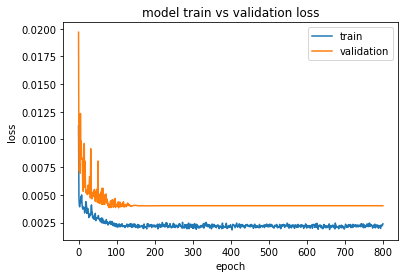

In [78]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [79]:
#predicting 246 values, using past 60 from the train data
inputs = data2.iloc[len(data2) - len(valid_set) - 60:,1:2].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = sc.transform(inputs)


In [80]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [81]:
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = regressor.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = sc.inverse_transform(inv_yhat)

In [82]:
lstm_sma_rms=np.sqrt(np.mean(np.power((valid_set-closing_price),2)))
lstm_sma_rms

711.6664829967017

<ipython-input-83-0930cda9a7cd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price[:,0]


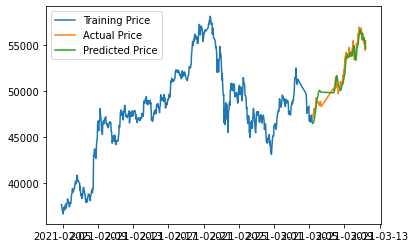

In [83]:
#for plotting
train = data2[:650]
valid = data2[650:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])